In [1]:
import pandas as pd
import spacy
from spacy.matcher import PhraseMatcher
import re
from typing import Optional

In [29]:
df = pd.read_csv("job_postings.csv")

In [73]:

def clean_job_title(title: str) -> str:
    """
    Cleans job titles by removing:
    - Gender markers (m/w/d, m/f/d, etc.)
    - Position levels (Senior, Junior, etc.)
    - Apprenticeship/study indicators
    - Special characters and extra whitespace
    - Location information
    - Percentage indicators
    - Years (2025, 2026, etc.)
    - Common small words (and, from, a, etc.)
    """
    original_title = title
    if not isinstance(title, str):
        return title
    
    # Convert to lowercase for consistent processing
    title = title.lower()
    
    # Remove gender markers and diversity indicators
    title = re.sub(
        r'\(?(m[\/\s]?[fw][\/\s]?d|f[\/\s]?m[\/\s]?d|all genders welcome|diverse|w[\/\s]?m[\/\s]?d|any gender)\)?',
        '', 
        title,
        flags=re.IGNORECASE
    )
    
    # Remove position levels (optional - keep if important for classification)
    title = re.sub(
        r'\b(senior|junior|lead|principal|associate|entry-level|mid-level|experienced|chief|head of)\b',
        '', 
        title
    )
    
    # Remove apprenticeship/study indicators
    title = re.sub(
        r'\b(azubi|apprentice|ausbildung|dual(?:es)? (?:study|studium)|werkstudent|working student|work student|student|practicum|internship|trainee)\b',
        '',
        title
    )
    
    # Remove years and percentages
    title = re.sub(r'(20[0-9]{2}|[0-9]{4})', '', title)
    title = re.sub(r'[0-9]{1,3}\s?%', '', title)
    
    # Remove location information (in brackets/parentheses)
    title = re.sub(r'\([^)]*\)', '', title)  # Remove everything in parentheses
    title = re.sub(r'\[[^\]]*\]', '', title)  # Remove everything in brackets
    title = re.sub(r'\bat\b.*$', '', title)   # Remove "at location" clauses
    title = re.sub(r'\bstandort\b.*$', '', title)  # Remove German location indicators
    
    # Remove special characters except hyphens (for compound terms)
    title = re.sub(r'[^\w\s-]', ' ', title)
    
    # Remove common small words
    title = re.sub(r'\b(and|from|a|an|the|in|of|for|with|on|at|as)\b', '', title)
    
    # Remove common corporate jargon
    jargon = [
        'focus on', 'focus', 'area of', 'in the area', 'field of', 
        'with specialization', 'specializing in', 'specialist for',
        'compulsory', 'limited', 'part-time', 'full-time',
        'remote', 'hybrid', 'onsite', 'hiring', 'position',
        'opportunity', 'role', 'job', 'early', 'start of', 'key',
        'corporate', 'Specialist', 'Area', 'teacher', 'professor'
    ]
    for term in jargon:
        title = title.replace(term, '')
    
    # Standardize common variations
    replacements = {
        r'\beng\b': 'engineer',
        r'\bdev\b': 'developer',
        r'\bmgr\b': 'manager',
        r'\bdir\b': 'director',
        r'\bvp\b': 'vice president',
        r'\bpm\b': 'project manager',
        r'\bki\b': 'artificial intelligence',
        r'\bai\b': 'artificial intelligence'
    }
    for pattern, replacement in replacements.items():
        title = re.sub(pattern, replacement, title)

    title = re.sub(r'\s+', ' ', title).strip()
    if not title:  # Fallback if we accidentally removed everything
        return original_title[:50].strip()
    
    # Remove department/division names
    title = re.sub(r'\b(group|department|division|team|center)\b.*$', '', title)
    
    title = title.title()  # Capitalize first letters (optional)
    
    
    return title


In [74]:
# Cleaning the data from unnecessary information

df["title"] = df.title.apply(clean_job_title)

In [78]:

# Load the language model
nlp = spacy.load("en_core_web_lg")

# Define the hierarchical job taxonomy
JOB_TAXONOMY = {
    "IT": {
        "Software Development": {
            "Frontend Development": [
                "frontend developer", "react engineer", "ui developer", "javascript specialist",
                "vue developer", "angular developer", "web developer"
            ],
            "Backend Development": [
                "backend engineer", "api developer", "java developer", "python developer",
                "golang developer", "nodejs developer", "spring boot engineer", "backend developer"
            ],
            "Full-Stack Development": [
                "full-stack developer", "mean stack engineer", "mern stack engineer",
                "software engineer", "web engineer", "Software Developer", "computer science"
            ],
            "Mobile Development": [
                "ios developer", "android developer", "flutter engineer", "react native developer",
                "mobile application developer", "kotlin developer", "swift developer"
            ],
            "Game Development": [
                "game developer", "unity engineer", "unreal engine programmer", "game designer", "level designer"
            ]
        },
        "DevOps & Cloud": {
            "DevOps Engineering": [
                "devops engineer", "site reliability engineer", "sre", "ci/cd specialist",
                "platform engineer", "automation engineer"
            ],
            "Cloud Engineering": [
                "aws engineer", "azure cloud architect", "google cloud engineer",
                "cloud solutions architect", "cloud infrastructure engineer"
            ],
            "Infrastructure & Networking": [
                "network engineer", "systems administrator", "it infrastructure manager",
                "network architect", "it systems engineer", "vpn specialist" 
            ]
        },
        "Data & AI": {
            "Data Science": [
                "data scientist", "machine learning engineer", "ai researcher",
                "statistical modeler", "data mining specialist", "data science"
            ],
            "Data Engineering": [
                "data engineer", "etl developer", "big data architect","data pipeline"
                "spark developer", "snowflake engineer", "delta lake specialist", "data warehouse"
            ],
            "Data Analysis": [
                "data analyst", "data analysis", "data management"
            ],
            "BI":[
                "bi","dashboard", "power bi developer", "tableau developer", "dax specialist", "business analyst"
                "business intelligence analyst", "bi developer", "business intelligence", "business analysis"
                "powerbi", "power bi", "tableau", "data visualization", "visualization"
            ],
            "AI, LLM & NLP": [
                "nlp engineer", "computer vision engineer", "deep learning specialist",
                "llm engineer", "genai engineer", "prompt engineer", "cv engineer", "ki",
            ],
            "Machine Learning":[
                "machine learning", "regression", "supervised learning", "unsupervised learning",
                "scikit learn", "pandas", "numpy", "matplotlib", "seaborn"
            ],
        },
        "Cybersecurity": {
            "Security Engineering": [
                "cybersecurity engineer", "penetration tester", "ethical hacker",
                "red team engineer", "blue team analyst"
            ],
            "Security Operations": [
                "soc analyst", "threat intelligence specialist", "incident responder",
                "forensics analyst", "malware analyst"
            ],
            "Governance & Compliance": [
                "security compliance manager", "risk analyst", "grc specialist",
                "it auditor", "iso 27001 consultant", "gdpr officer"
            ]
        },
        "IT Management": {
            "Engineering Leadership": [
                "engineering manager", "vp of engineering", "cto", "tech lead", "team lead"
            ],
            "Product & Project Management": [
                "technical product manager", "it project manager", "scrum master",
                "agile coach", "release manager", "delivery manager"
            ],
            "Enterprise Architecture": [
                "solution architect", "enterprise architect", "technical architect"
            ]
        },
        "QA & Testing": {
            "Manual Testing": [
                "qa tester", "test analyst", "software tester"
            ],
            "Automation Testing": [
                "qa automation engineer", "sdet", "performance tester",
                "selenium engineer", "test automation architect"
            ],
            "QA Management": [
                "qa manager", "test lead", "qa coordinator"
            ]
        },
        "IT Support": {
            "Helpdesk & Support": [
                "it support specialist", "helpdesk technician", "desktop support",
                "first level support", "second level support", "technischer support"
            ],
            "Database Administration": [
                "dba", "sql developer", "database architect", "postgres admin", "mysql expert"
            ],
            "ERP & Business Systems": [
                "sap consultant", "sap developer", "sap basis administrator",
                "salesforce admin", "crm consultant", "microsoft dynamics consultant", "Digital Network"
            ]
        }
    },
    "Business": {
        "Finance": {
            "Accounting": [
                "accountant", "financial analyst", "auditor", "buchhalter", "controller"
            ],
            "Banking & Investment": [
                "investment banker", "financial advisor", "risk manager", "credit analyst"
            ]
        },
        "Sales & Marketing": {
            "Sales": [
                "sales executive", "account manager", "business development",
                "vertrieb", "sales consultant", "presales engineer"
            ],
            "Digital Marketing": [
                "seo specialist", "ppc manager", "growth marketer",
                "performance marketer", "online marketing manager"
            ]
        },
        "HR": {
            "Recruitment": [
                "technical recruiter", "hr business partner", "talent acquisition specialist"
            ],
            "HR Operations": [
                "hr manager", "payroll specialist", "hr generalist", "personalsachbearbeiter"
            ]
        },
        "Administration & Legal": {
            "Office Administration": ["office manager", "executive assistant", "administrative coordinator"],
            "Legal & Compliance": ["legal counsel", "compliance officer", "contract manager"]
        },
        "Procurement": {
            "Strategic Sourcing": ["procurement specialist", "buyer"],
            "Supply Chain": ["supply chain manager", "logistics"],
            "Vendor Management": ["vendor development", "supplier manager"]
        },
        "Finance": {
            "Wealth Management": ["private wealth", "portfolio manager"],
            "Corporate Finance": ["mergers acquisitions", "m&a"],
            "Risk Management": ["risk controller", "insurance risk"]
        }
    },
    "Engineering": {
        "Mechanical Engineering": ["mechanical engineer", "mechatronics engineer"],
        "Electrical Engineering": ["electrical engineer", "power systems engineer"],
        "Civil & Structural": ["civil engineer", "structural engineer", "construction engineer"],
        "Automotive & Aerospace": ["automotive engineer", "aerospace engineer", "vehicle dynamics specialist"],
        "Chemical & Process": ["chemical engineer", "process engineer", "materials engineer"],
        "Industrial & Systems": ["industrial engineer", "manufacturing engineer", "systems engineer", "system engineer",
                                "production technology", "plant mechanic", "coating technology", "process specialist",
                                "quality engineer", "testing specialist"]
    },
    "Healthcare": {
        "Medical Practice": ["doctor", "physician", "surgeon", "general practitioner"],
        "Nursing": ["nurse", "registered nurse", "icu nurse"],
        "Therapy & Support": ["physiotherapist", "occupational therapist", "speech therapist"],
        "Pharmacy & Labs": ["pharmacist", "lab technician", "clinical researcher"],
        "Public Health": ["epidemiologist", "health policy analyst", "public health nurse"]
    },
    "Education": {
        "School Teaching": ["primary school teacher", "secondary school teacher", "special education teacher"],
        "University & Research": ["lecturer", "professor", "research associate"],
        "Training & eLearning": ["corporate trainer", "instructional designer", "elearning specialist"]
    },
    "Logistics & Supply Chain": {
        "Logistics Management": ["logistics manager", "warehouse manager", "supply chain planner"],
        "Transportation": ["delivery driver", "truck driver", "logistics coordinator"],
        "Procurement & Planning": ["procurement officer", "demand planner", "inventory controller"]
    },
    "Manufacturing & Production": {
        "Plant Operations": ["production operator", "plant supervisor", "machinist"],
        "Maintenance": ["maintenance technician", "electromechanic", "industrial mechanic"],
        "Quality Control": ["quality inspector", "qa technician", "qc analyst"]
    },
    "Construction & Skilled Trades": {
        "Construction": ["construction worker", "site manager", "bricklayer"],
        "Skilled Trades": ["electrician", "plumber", "carpenter", "welder"],
        "Project Management": ["construction project manager", "site supervisor"]
    },
    "Media & Design": {
        "Graphic & Visual Design": ["graphic designer", "ui/ux designer", "motion designer"],
        "Content & Writing": ["copywriter", "content writer", "technical writer"],
        "Marketing & PR": ["brand manager", "pr specialist", "communications officer"]
    },
    "Legal": {
        "Legal Practice": ["lawyer", "solicitor", "barrister", "legal advisor"],
        "Legal Support": ["paralegal", "legal assistant", "contract administrator"],
        "Compliance & Regulatory": ["compliance officer", "data protection officer"]
    },
    "Customer Service": {
        "Call Center": ["customer service representative", "call center agent", "support agent"],
        "Client Relations": ["account coordinator", "customer success manager", "support specialist"]
    },
    "Public Sector & Non-Profit": {
        "Government": ["civil servant", "policy advisor", "administrative officer"],
        "NGO & Charity": ["program coordinator", "fundraiser", "non-profit manager"],
        "Education & Research": ["public research analyst", "education officer"]
    },
    "Hospitality & Tourism": {
        "Hotel & Restaurant": ["receptionist", "chef", "waiter", "hotel manager"],
        "Travel Services": ["travel agent", "tour guide", "concierge"]
    },
    "Retail & Consumer": {
        "Retail Sales": ["retail assistant", "store manager", "cashier"],
        "Inventory & Merchandising": ["stock clerk", "visual merchandiser", "inventory specialist"]
    },
    "Project Manager":{
        "project manager", "project management", "Projektmanager"
    }

}


class JobTitleClassifier:
    def __init__(self):
        self.matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
        self._build_matcher()
        
    def _build_matcher(self):
        """Build phrase matcher from taxonomy"""
        for main_cat, subcats in JOB_TAXONOMY.items():
            if isinstance(subcats, dict):
                for subcat, subsubcats in subcats.items():
                    if isinstance(subsubcats, dict):
                        for subsubcat, terms in subsubcats.items():
                            patterns = [nlp(text) for text in terms]
                            self.matcher.add(f"{main_cat}|{subcat}|{subsubcat}", patterns)
                    else:
                        patterns = [nlp(text) for text in subsubcats]
                        self.matcher.add(f"{main_cat}|{subcat}", patterns)
    
    def classify(self, title):
        """Classify a job title into the hierarchy"""
        doc = nlp(title.lower())
        matches = self.matcher(doc)
        
        if matches:
            # Get the most specific match (longest path)
            match_ids = [nlp.vocab.strings[match_id] for match_id, _, _ in matches]
            return max(match_ids, key=lambda x: len(x.split("|")))
        
        # Fallback: Use similarity for unclassified titles
        return self._classify_with_similarity(title)
    
    def _classify_with_similarity(self, title):
        """Fallback classifier using semantic similarity"""
        doc = nlp(title.lower())
        best_score = 0
        best_category = "Other"
        
        # Flatten taxonomy for similarity comparison
        flat_taxonomy = {}
        for main_cat, subcats in JOB_TAXONOMY.items():
            if isinstance(subcats, dict):
                for subcat, subsubcats in subcats.items():
                    if isinstance(subsubcats, dict):
                        for subsubcat, terms in subsubcats.items():
                            for term in terms:
                                flat_taxonomy[f"{main_cat}|{subcat}|{subsubcat}"] = term
                    else:
                        for term in subsubcats:
                            flat_taxonomy[f"{main_cat}|{subcat}"] = term
        
        # Compare with all terms
        for category, example in flat_taxonomy.items():
            example_doc = nlp(example)
            similarity = doc.similarity(example_doc)
            if similarity > best_score and similarity > 0.7:
                best_score = similarity
                best_category = category
        
        return best_category

# Example usage
classifier = JobTitleClassifier()

# titles = clean_titles

# for title in titles:
# classification = classifier.classify(title)
    # print(f"{title: <30} => {classification}")

In [80]:
#  applying the best classifier for the the job type

classification = df.title.apply(classifier.classify)

/var/folders/5w/y91gtvg50551n3s4nv78b_q00000gn/T/ipykernel_30222/3731998240.py:286: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity = doc.similarity(example_doc)


In [84]:
df["job_category"] = classification

In [91]:
df.job_category.value_counts()

job_category
Other                                             1706
IT|Data & AI|Data Analysis                         450
Business|Sales & Marketing|Digital Marketing       259
IT|Software Development|Full-Stack Development     225
Business|Sales & Marketing|Sales                   136
                                                  ... 
IT|Data & AI|AI, LLM & NLP                           1
Manufacturing & Production|Quality Control           1
IT|Software Development|Mobile Development           1
Retail & Consumer|Retail Sales                       1
Engineering|Automotive & Aerospace                   1
Name: count, Length: 74, dtype: int64

<bound method Series.count of 0       False
1       False
2       False
3       False
4       False
        ...  
4544    False
4545    False
4546    False
4547    False
4548    False
Name: job_category, Length: 4516, dtype: bool>

In [102]:
other_category = df[df.job_category == "Other"]
df1 = df.copy()

In [114]:
df1[(df1.job_category == "Other") & (df1.title.str.contains("artificial intelligence", case=False))] = \
other_category[other_category.title.str.contains("Artificial Intelligence")].replace("Other", "IT|Data & AI|AI, LLM & NLP")

In [115]:
df1[df1.title.str.contains("Artificial Intelligence")]

,title,company,location,job_type,employment_type,description,requirements,job_category
1,Procurement Specialist Data Science Artificial...,Leadec Management Central Europe BV & Co. KG,Stuttgart,Feste Anstellung,"Homeoffice möglich, Vollzeit","With 14,500 employees worldwide and more than ...",You bring many years of professional experienc...,Business|Procurement|Strategic Sourcing
2,Dhbw Studies - Data Science Artificial Intelli...,Liebherr-International Deutschland GmbH,Biberach,NaN,NaN,Monari is a future-oriented and international ...,Successfully completed degree in business info...,IT|Data & AI|Data Science
4,Dual Studies Data Science Artificial Intelligence,Deloitte,"Düsseldorf, Mannheim, Stuttgart","Ausbildung, Studium",Vollzeit,ZS2Radätteilen GmbH is one of the leading Germ...,Completed scientific university studies in com...,IT|Data & AI|Data Science
5,Dual Studies Data Science Artificial Intellige...,Lidl Stiftung & Co. KG,Neckarsulm,"Ausbildung, Studium",Vollzeit,Everything started with an adhesive film. Toda...,A completed course of study in a relevant area...,IT|Data & AI|Data Science
8,Data Science Artificial Intelligence,Schwarz Corporate Solutions,"Neckarsulm, Heilbronn","Ausbildung, Studium",Vollzeit,Our over 30-year success story in the software...,A successfully completed degree in the field o...,IT|Data & AI|Data Science
...,...,...,...,...,...,...,...,...
4285,Artificial Intelligence Ml Engineer - Nlp Llm ...,Cinemo GmbH,Hybrid,Feste Anstellung,Vollzeit,Upvest is on a mission to make investing as ea...,You have a completed tax consultant exam or ar...,"IT|Data & AI|AI, LLM & NLP"
4360,Research Staff-Artificial Intelligence Scienti...,Hochschule Mittweida University Of Applied Sci...,Mittweida,Befristeter Vertrag,"Homeoffice möglich, Teilzeit","The University of Mittweida, University of App...",· Completed scientific university degree / com...,Education|University & Research
4402,Artificial Intelligence Research Engineer - Ar...,Helsing GmbH,München,Feste Anstellung,Vollzeit,At Helsing we deliver AI-based capabilities an...,Your profileYou’re passionate about innovative...,"IT|Data & AI|AI, LLM & NLP"
4420,Founders - Artificial Intelligence Ml Consulting,Code17 GmbH,Leipzig,Feste Anstellung,"Homeoffice möglich, Vollzeit","As a lean, bootstrapped team of 12, Code17 Gmb...",At least 2 years of successfully completed tra...,"IT|Data & AI|AI, LLM & NLP"


In [118]:
df = df1
df

,title,company,location,job_type,employment_type,description,requirements,job_category
0,Business Analyst - Im,Markant Gruppe,Offenburg,Feste Anstellung,"Homeoffice möglich, Vollzeit",There is a lot of know-how in our medium-sized...,Ongoing studies in the field of computer scien...,Public Sector & Non-Profit|NGO & Charity
1,Procurement Specialist Data Science Artificial...,Leadec Management Central Europe BV & Co. KG,Stuttgart,Feste Anstellung,"Homeoffice möglich, Vollzeit","With 14,500 employees worldwide and more than ...",You bring many years of professional experienc...,Business|Procurement|Strategic Sourcing
2,Dhbw Studies - Data Science Artificial Intelli...,Liebherr-International Deutschland GmbH,Biberach,NaN,NaN,Monari is a future-oriented and international ...,Successfully completed degree in business info...,IT|Data & AI|Data Science
3,Data Science Area Python Databricks,ARAG SE,Düsseldorf,"Studentenjobs, Werkstudent","Homeoffice möglich, Teilzeit",IONITY is a joint venture of the car manufactu...,You have a successfully completed degree in th...,IT|Data & AI|Data Science
4,Dual Studies Data Science Artificial Intelligence,Deloitte,"Düsseldorf, Mannheim, Stuttgart","Ausbildung, Studium",Vollzeit,ZS2Radätteilen GmbH is one of the leading Germ...,Completed scientific university studies in com...,IT|Data & AI|Data Science
...,...,...,...,...,...,...,...,...
4544,It Specialist,FERCHAU – Connecting People and Technologies,Norderstedt,Feste Anstellung,"Homeoffice möglich, Vollzeit","Combining people and technologies, designing t...",Completed university education at an applied u...,Customer Service|Client Relations
4545,Project Coordinator Formulation Process Develo...,FERCHAU – Connecting People and Technologies,Biberach an der Riß,Feste Anstellung,Vollzeit,You don't want to leave your career developmen...,Practice from the user support: You have well-...,Other
4546,Quercomers Production Pharmaceutical,FERCHAU – Connecting People and Technologies,Biberach an der Riß,Feste Anstellung,Vollzeit,You don't want to leave your career developmen...,Technical basis with depth: You have several y...,Other
4547,Laborant Cta Bta,FERCHAU – Connecting People and Technologies,Biberach an der Riß,Feste Anstellung,Vollzeit,Finding the best minds for a wide variety of t...,Completed training as an IT system administrat...,Other


In [130]:
indexes_to_drop = df[(df.job_category == "Other") & (df.title.str.contains("data", case = False))].index

In [134]:
df.drop(indexes_to_drop, inplace = True)

In [149]:
pattern = r"projektmanager|project manager|project management"

mask = (df.job_category == "Other") & (df.title.str.contains(pattern, case=False))
df.loc[mask, 'job_category'] = "Project Manager"


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


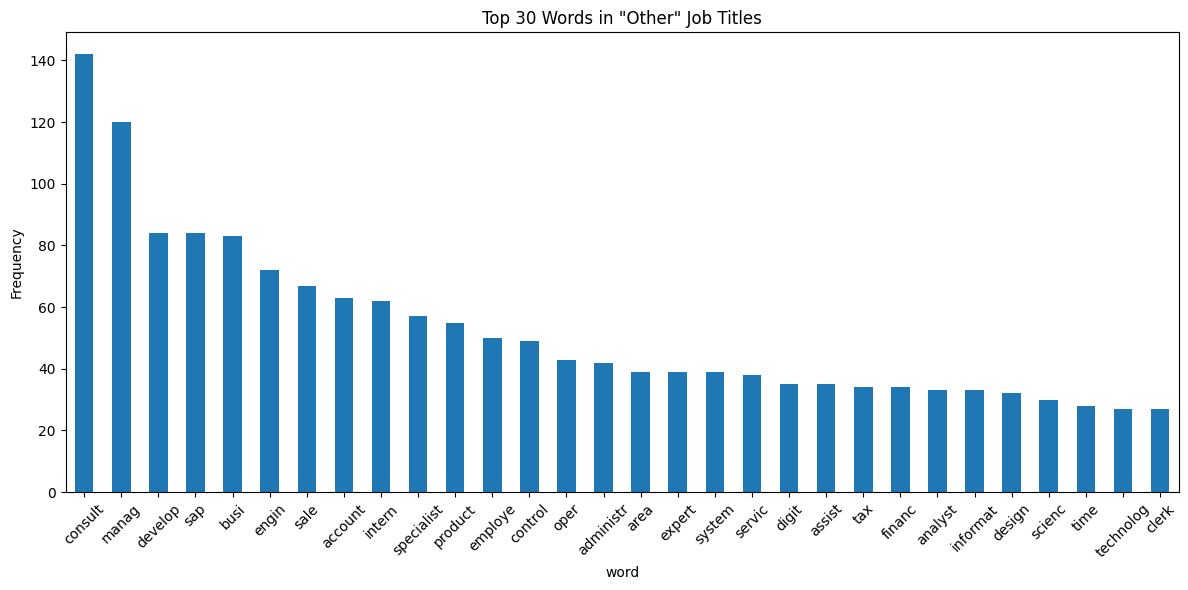

In [260]:
# Dealing with other job category
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter

nltk.download('stopwords')
stemmer = PorterStemmer()

# Custom stopwords
custom_stopwords = set(stopwords.words('english'))

def process_text(text):
    text = str(text).lower()
    words = re.findall(r'\b[a-z]{2,}\b', text)  # Only words with 2+ letters
    words = [stemmer.stem(w) for w in words if w not in custom_stopwords]
    return words

all_words = []
for title in df[df['job_category'] == 'Other']['title']:
    all_words.extend(process_text(title))

word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.most_common(30), 
                        columns=['word', 'count'])

# Visualization
plt.figure(figsize=(12, 6))
word_freq.set_index('word')['count'].plot(kind='bar')
plt.title('Top 30 Words in "Other" Job Titles')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [300]:
mask = (df.job_category == "Other")
mask

0       False
1       False
2       False
3       False
4       False
        ...  
4544    False
4545     True
4546     True
4547     True
4548    False
Name: job_category, Length: 4516, dtype: bool

In [262]:
def title_cleaning_other(title):
    stems = [
        r'consult', r'manag', r'develop', r'engin',    
        r'sale', r'account', r'sap', r'intern',
        r'specialist', r'product', r'employe',
        r'control', r'oper', r'administr',
        r'area', r'expert', r'system', 'servic'
        
    ]
    pattern = r'\b\w*(' + '|'.join(stems) + r')\w*\b'
    cleaned_title = re.sub(pattern, '', title, flags=re.IGNORECASE)
    cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
    
    return cleaned_title

In [346]:
# first we clean the titles
df2 = df[mask].title.apply(title_cleaning_other)
# then we classify them again
# df_temp["job_category"] = df_temp.title.apply(classifier.classify)

In [347]:
df2 = pd.DataFrame(df2,columns=["title"])


In [353]:
drop_empty_index = df2[df2["title"].fillna("").str.len() == 0].index

In [354]:
df2.drop(drop_empty_index, inplace = True)

In [356]:
# df.drop(drop_empty_index, inplace = True)

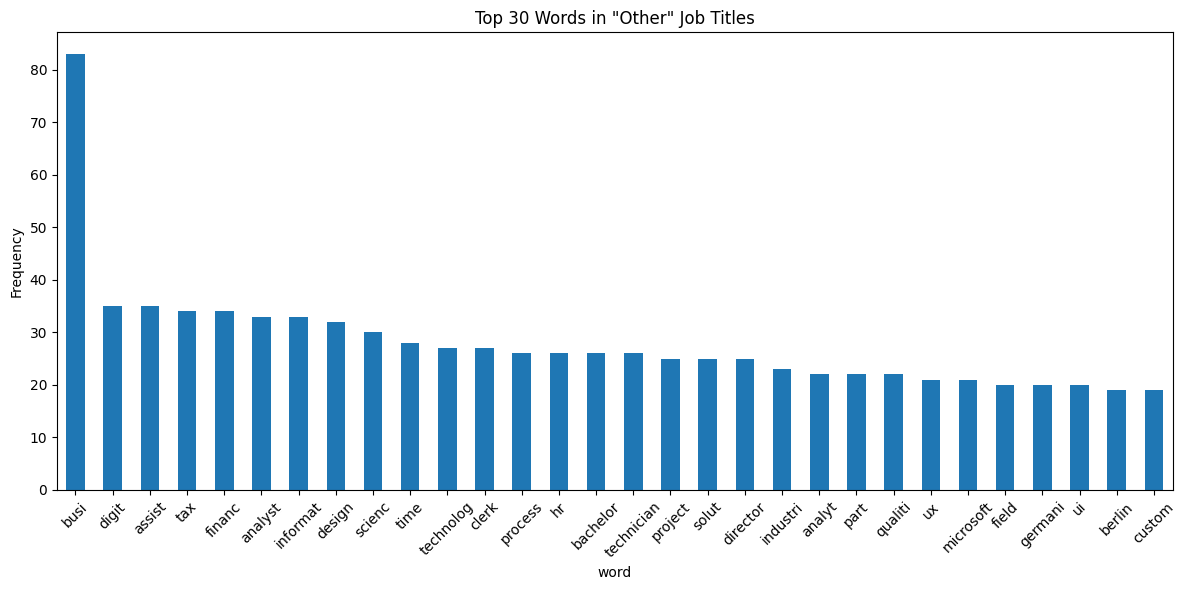

In [358]:
all_words = []
for title in df2.title :
    all_words.extend(process_text(title))

word_counts = Counter(all_words)
word_freq = pd.DataFrame(word_counts.most_common(30), 
                        columns=['word', 'count'])

# Visualization
plt.figure(figsize=(12, 6))
word_freq.set_index('word')['count'].plot(kind='bar')
plt.title('Top 30 Words in "Other" Job Titles')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [365]:
df2.title

66      Final Thesis Validation Routing Algorithm Betw...
70                                      Programming Tutor
74                                                Content
77                        Insurance Mathematician Acarrow
80                                     Telecommunications
                              ...                        
4540                 Digital Customer Experience C24 Bank
4543                           Credit Collection C24 Bank
4545              Project Coordinator Formulation Process
4546                            Quercomers Pharmaceutical
4547                                     Laborant Cta Bta
Name: title, Length: 1481, dtype: object

In [403]:
pd.set_option('display.max_rows', 200)
df2.sample(200, random_state=1,)
# most of these jobs are junk jobs not related to the study

,title
1154,Finance Part -Time
3098,Breafinery
517,New Processing Pilot
3420,Natural Scientist Technician
1944,Analyst Fp
3144,Move World - Or
4473,Application Ux Designer
1534,Application Technologist Baking
1389,Abap Entwickler - Abap
3408,Praktikum - Tech Business Automation Im Ventur...


In [377]:
df[(df.job_category == "Other") & (df1.title.str.contains("security|cybersecurity|penetration", case=False))] = \
other_category[other_category.title.str.contains("security|cybersecurity|penetration")].replace("Other", "IT|Cybersecurity|Security Engineering")

In [384]:
df[(df.job_category == "Other") & (df1.title.str.contains("software", case=False))] = \
other_category[other_category.title.str.contains("software")].replace("Other", "IT|Software Development|Full-Stack Development")

In [391]:
df[(df.job_category == "Other") & (df1.title.str.contains("informatics", case=False))]= \
other_category[other_category.title.str.contains("informatics")].replace("Other", "IT|Data & AI|Data Analysis")

In [393]:
df[(df.job_category == "Other") & (df1.title.str.contains("cloud", case=False))] = \
other_category[other_category.title.str.contains("cloud")].replace("Other", "IT|DevOps & Cloud|Cloud Engineering")

In [401]:
df[(df.job_category == "Other") & (df1.title.str.contains("business analys", case=False))] = \
other_category[other_category.title.str.contains("business analys")].replace("Other", "IT|Data & AI|BI")

In [420]:
pd.set_option('display.max_rows', 1384)
df[df.job_category == "Other"]

,title,company,location,job_type,employment_type,description,requirements,job_category
66,Final Thesis Validation Routing Algorithm Betw...,TKMS ATLAS ELEKTRONIK GmbH,Bremen,Bachelor-/Master-/Diplom-Arbeiten,Vollzeit,Even if we - the HSAG - appear in our name in ...,7+ years of hands-on experiencein developing a...,Other
70,Programming Tutor,Coding Giants,Düsseldorf,Feste Anstellung,"Homeoffice möglich, Vollzeit",Bonprix is one of Otto Group's highest sales b...,Completed training as a chemical laboratoryist...,Other
74,Content Development,Saatmann GmbH,Worms,"Studentenjobs, Werkstudent","Homeoffice möglich, Teilzeit","“Research for a life without cancer"" is our mi...",How do you fit into our team? You bring a gene...,Other
77,Insurance Mathematician Acarrow,KPMG AG Wirtschaftsprüfungsgesellschaft,"München, Köln, Frankfurt, Hamburg, Düsseldorf,...",Feste Anstellung,"Homeoffice möglich, Vollzeit",A world without accidents at work and work -re...,Note on online advertising: Please upload your...,Other
80,Consultant Telecommunications,Sopra Steria,"bundesweit, Berlin, Frankfurt, Hamburg, Köln, ...",Feste Anstellung,"Homeoffice möglich, Vollzeit",Otto is one of the most successful e-commerce ...,Abitur (general or subject-bound) or technical...,Other
87,Autering - Risk Modeling Reservation,ARAG SE,Düsseldorf,Feste Anstellung,"Homeoffice möglich, Vollzeit",Changing the world through digital experiences...,"Ideally, you bring the following with: Success...",Other
99,Afc Modelling Manager,N26 GmbH,Berlin,Feste Anstellung,"Homeoffice möglich, Vollzeit",Check one at Munich Airport - one of the most ...,"A degree in data science, computer science, bu...",Other
102,Praktikum Founders Im Travel-Tech Startup,YGO GmbH,Berlin,Praktikum,Vollzeit,Location: 51149 Cologne | Type of contract: fu...,You have completed a degree in economic scienc...,Other
103,Climate Risk Intern,Münchener Rückversicherungs-Gesellschaft AG,München,Praktikum,Vollzeit,Liebherr-Werk Biberach GmbH produces high-qual...,Training: You have a completed degree in compu...,Other
113,Master Thesis Development Car Code Precise See...,TKMS ATLAS ELEKTRONIK GmbH,Bremen,Bachelor-/Master-/Diplom-Arbeiten,Vollzeit,GEA is one of the largest providers for the fo...,Professional experience: You have several year...,Other


# after checking all the rows we can confidently say that there are no important data mostly irrelevent jobs and some special niche jobs

In [423]:
other_drop_indexes = df[df.job_category == "Other"].index
df = df.drop(other_drop_indexes)

In [426]:
df

,title,company,location,job_type,employment_type,description,requirements,job_category
0,Business Analyst - Im,Markant Gruppe,Offenburg,Feste Anstellung,"Homeoffice möglich, Vollzeit",There is a lot of know-how in our medium-sized...,Ongoing studies in the field of computer scien...,Public Sector & Non-Profit|NGO & Charity
1,Procurement Specialist Data Science Artificial...,Leadec Management Central Europe BV & Co. KG,Stuttgart,Feste Anstellung,"Homeoffice möglich, Vollzeit","With 14,500 employees worldwide and more than ...",You bring many years of professional experienc...,Business|Procurement|Strategic Sourcing
2,Dhbw Studies - Data Science Artificial Intelli...,Liebherr-International Deutschland GmbH,Biberach,NaN,NaN,Monari is a future-oriented and international ...,Successfully completed degree in business info...,IT|Data & AI|Data Science
3,Data Science Area Python Databricks,ARAG SE,Düsseldorf,"Studentenjobs, Werkstudent","Homeoffice möglich, Teilzeit",IONITY is a joint venture of the car manufactu...,You have a successfully completed degree in th...,IT|Data & AI|Data Science
4,Dual Studies Data Science Artificial Intelligence,Deloitte,"Düsseldorf, Mannheim, Stuttgart","Ausbildung, Studium",Vollzeit,ZS2Radätteilen GmbH is one of the leading Germ...,Completed scientific university studies in com...,IT|Data & AI|Data Science
...,...,...,...,...,...,...,...,...
4539,Operations Manager Customer Service C24 Bank,CHECK24,Frankfurt am Main,Feste Anstellung,Vollzeit,C24 Bank GmbH is part of the Check24 Group. Un...,Completed studies (diploma [FH]/Bachelor) in t...,IT|IT Management|Product & Project Management
4541,Cloud Architekt,ZDF,Mainz,Feste Anstellung,"Teilzeit, Vollzeit",The Planning and Realization business area (PU...,You have a completed training as a bank clerk ...,IT|DevOps & Cloud|Cloud Engineering
4542,It Service Engineer-Analyst Smart Meter Softwa...,Schleupen SE,Ettlingen,Feste Anstellung,"Homeoffice möglich, Vollzeit",We are an innovative medium -sized software co...,Completed vocational training as a specialist ...,Engineering|Electrical Engineering
4544,It Specialist,FERCHAU – Connecting People and Technologies,Norderstedt,Feste Anstellung,"Homeoffice möglich, Vollzeit","Combining people and technologies, designing t...",Completed university education at an applied u...,Customer Service|Client Relations


In [435]:
df.to_csv("job_postings_classified.csv")